# Baseline Neural Network


### Focus on Electrode 5

In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import numpy as np
import json
import pandas as pd
import numpy as np
import time
import string
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
sys.path.append('../../../')
from brain2brain import utils, generators, models
%matplotlib inline

# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# TCN
from brain2brain.tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM, RepeatVector, TimeDistributed, Lambda

from scipy.stats import pearsonr

from brain2brain import utils, models

In [3]:
train_bin_norm_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_2.txt")
val_bin_norm_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_bin_norm_2.txt")
total_electrode_count = utils.get_file_shape(train_bin_norm_paths[0])[1]
# Electrodes
electrode_count = 114
electrode = 5
electrodes = range(114)
length_pred = 20
pred_length = length_pred
lookback = 100
delay = 0
length = 20
# Training Generator
train_generator = generators.FGenerator(file_paths=train_bin_norm_paths,
                                        lookback=100,
                                        length=20,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=electrodes,
                                        electrode_output_ix=electrode,
                                        shuffle=True)
# Validation Generator
val_generator = generators.FGenerator(file_paths=val_bin_norm_paths,
                                        lookback=100,
                                        length=20,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=electrodes,
                                        electrode_output_ix=electrode,
                                        shuffle=False)

(5429, 114)


In [4]:
train_generator[0][0].shape

(1024, 100, 114)

In [5]:
train_generator[0][1].shape

(1024, 20, 1)

In [6]:
val_generator[0][1].shape

(1024, 20, 1)

In [7]:
val_generator[0][0].shape

(1024, 100, 114)

In [8]:
# Model Architecture
input_layer = Input(shape=(None, electrode_count))
x = TCN(nb_filters=32,
        kernel_size=4,
        dilations=[1, 2, 4, 8, 16],
        nb_stacks=2,
        padding="causal",
        use_skip_connections=True,
        return_sequences=True,
        activation="linear",
        dropout_rate=0.05,
        kernel_initializer="he_normal")(input_layer)
x = Dense(1)(x)
# Workaround because config does not work with copy.deepcopy
# https://github.com/wandb/client/issues/833 fix does not work
length_pred = 20
x = Lambda(lambda x: x[:, -length_pred:, :])(x)
output_layer = x
model = Model(input_layer, output_layer)
model.compile(optimizer=Adam(), loss="mae")
model.summary()

(None, None, 114)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 114)]       0         
_________________________________________________________________
tcn (TCN)                    (None, None, 32)          95744     
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 95,777
Trainable params: 95,777
Non-trainable params: 0
_________________________________________________________________


In [9]:
callback_list = [
#         EarlyStopping(
#             monitor="val_loss",
#             patience=5,
#             mode="min"
#         )
]
history = model.fit_generator(generator=train_generator,
                              callbacks=callback_list,
                              epochs=100,
                              validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 12 steps, validate for 4 steps
Epoch 1/100
12/12 [==============================] - 42s 3s/step - loss: 100.8381 - val_loss: 34.1597
Epoch 2/100
12/12 [==============================] - 5s 398ms/step - loss: 31.0034 - val_loss: 16.3963
Epoch 3/100
12/12 [==============================] - 5s 395ms/step - loss: 18.0600 - val_loss: 10.7616
Epoch 4/100
12/12 [==============================] - 5s 394ms/step - loss: 12.6699 - val_loss: 7.8799
Epoch 5/100
12/12 [==============================] - 5s 394ms/step - loss: 9.7045 - val_loss: 6.2058
Epoch 6/100
12/12 [==============================] - 5s 394ms/step - loss: 7.7855 - val_loss: 5.0347
Epoch 7/100
12/12 [==============================] - 5s 411ms/step - loss: 6.4508 - val_loss: 4.1537
Epoch 8/100
12/12 [==============================] - 5s 395ms/step - loss: 5.3745 - val_loss: 3.4695
Epoch 9/100
12/12 [

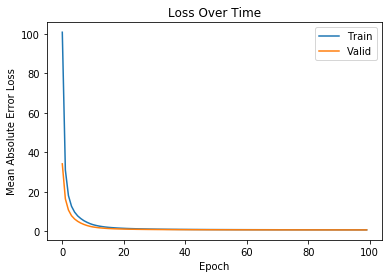

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [12]:
from tensorflow.keras.models import model_from_json

file_name = "models/tcn_m2o"
# serialize model to JSON
model_json = model.to_json()
with open(f"{file_name}.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(f"{file_name}.h5")

ValueError: Unknown layer: TCN

In [5]:
from tensorflow.keras.models import model_from_json
file_name = "models/tcn_m2o_2"

# load json and create model
json_file = open(f'{file_name}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json, custom_objects={'TCN': TCN})
# load weights into new model
model.load_weights(f"{file_name}.h5")
print("Loaded model from disk")

(None, None, 114)
Loaded model from disk


# Evaluate Sequences

In [8]:
inf_generator = generators.FGenerator(file_paths=val_bin_norm_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=electrodes,
                                        shuffle=False,
                                        teacher_forcing=True,
                                        teacher_forcing_concat=True)

In [9]:
def predict_sequence_m2o(input_sequence,
                         history_sequence_target,
                         pred_steps,
                         electrode,
                         model):
    lookback = input_sequence.shape[1]
    electrode_count = history_sequence_target.shape[1]
    pred_sequence = np.zeros((pred_steps,)) # initialize output (pred_steps time steps)  
    history_sequence = input_sequence
#     print(history_sequence.shape)
    history_sequence_target = np.array([history_sequence_target])
#     print(history_sequence_target.shape)

    for i in range(pred_steps):
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)
#         last_step_pred = last_step_pred.reshape(-1)
        
        pred_sequence[i] = last_step_pred[:, -1, :]
#         print(pred_sequence.shape)
        history_sequence_target[0, i, electrode] = pred_sequence[i]
#         print(history_sequence_target.shape)
#         print(history_sequence_target[:, i, electrode].shape)
#         print(history_sequence_target[:, i, :].shape)
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence[:, -(lookback-1):, :], 
                                           history_sequence_target[:, i, :].reshape(1, 1, electrode_count)], axis=1)
#     print(len(pred_sequence))
    return pred_sequence

In [10]:
def predict_and_plot(encoder_input_data, decoder_target_data, inf_target, sample_ix, pred_steps: int,electrode, enc_tail_len=100):
    encode_series = encoder_input_data[sample_ix:sample_ix+1,:,:] 
    history_sequence_target = inf_target[sample_ix, :, :]
    pred_series = predict_sequence_m2o(encode_series,
                                       history_sequence_target,
                                       pred_steps,
                                       electrode,
                                       model)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_series.reshape(-1)))
    print(f"Correlation: {r}. P: {p}. Mae: {mae}")
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [11]:
val_batch = val_generator[0]
inf_batch = inf_generator[0]

In [12]:
val_batch[0].shape

(1024, 100, 114)

Correlation: -0.0426688308713983. P: 0.8582403209854714. Mae: 0.5389960166399705


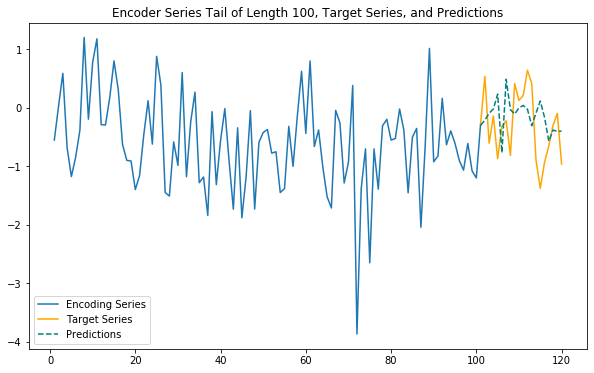

In [13]:
predict_and_plot(val_batch[0], val_batch[1], inf_batch[1],electrode=electrode, sample_ix=0, pred_steps=20)

In [50]:
# def predict_sequence_m2o(input_sequence,
#                          history_sequence_target,
#                          pred_steps,
#                          electrode,
#                          model):
#     lookback = input_sequence.shape[1]
#     electrode_count = history_sequence_target.shape[1]
#     pred_sequence = np.zeros((pred_steps,)) # initialize output (pred_steps time steps)  
#     history_sequence = input_sequence
# #     print(history_sequence.shape)
#     history_sequence_target = np.array([history_sequence_target])
# #     print(history_sequence_target.shape)

#     for i in range(pred_steps):
#         # record next time step prediction (last time step of model output) 
#         last_step_pred = model.predict(history_sequence)
# #         last_step_pred = last_step_pred.reshape(-1)
        
#         pred_sequence[i] = last_step_pred[:, -1, :]
# #         print(pred_sequence.shape)
#         history_sequence_target[0, i, electrode] = pred_sequence[i]
# #         print(history_sequence_target.shape)
# #         print(history_sequence_target[:, i, electrode].shape)
# #         print(history_sequence_target[:, i, :].shape)
        
#         # add the next time step prediction to the history sequence
#         history_sequence = np.concatenate([history_sequence[:, -(lookback-1):, :], 
#                                            history_sequence_target[:, i, :].reshape(1, 1, electrode_count)], axis=1)
# #     print(len(pred_sequence))
#     return pred_sequence

In [51]:
# def predict_and_plot(model,
#                      input_sequnece_batch,
#                      target_sequence_batch,
#                      sample_ix,
#                      pred_steps: int,
#                      enc_tail_len=100):
#     input_sequence = input_sequnece_batch[sample_ix]
#     target_sequence = target_sequence_batch[sample_ix]
#     pred_series = predict_sequence_m2o(input_sequence,
#                                               pred_steps, model, 114)
#     input_sequence = input_sequence.reshape(-1,1)
#     pred_series = pred_series.reshape(-1,1)   
#     target_sequence = target_sequence.reshape(pred_steps,1)
#     print(target_sequence.shape)
#     input_sequence_tail = np.concatenate([input_sequence[-enc_tail_len:],target_sequence[:1]])
#     x_encode = input_sequence_tail.shape[0]
    
#     r, p = pearsonr(pred_series.reshape(-1), target_sequence.reshape(-1))
#     mae = np.mean(np.abs(pred_series.reshape(-1) - target_sequence.reshape(-1))) 
#     print(f"Correlation: {r}. P: {p}. MAE {mae}")
#     plt.figure(figsize=(10,6))   
    
#     plt.plot(range(1,x_encode+1), input_sequence_tail)
#     plt.plot(range(x_encode,x_encode+pred_steps),target_sequence,color='orange')
#     plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
#     plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
#     plt.legend(['Encoding Series','Target Series','Predictions'])


(20, 1)
Correlation: -0.2304185126595311. P: 0.3283969320338323. MAE 0.7609286167313467


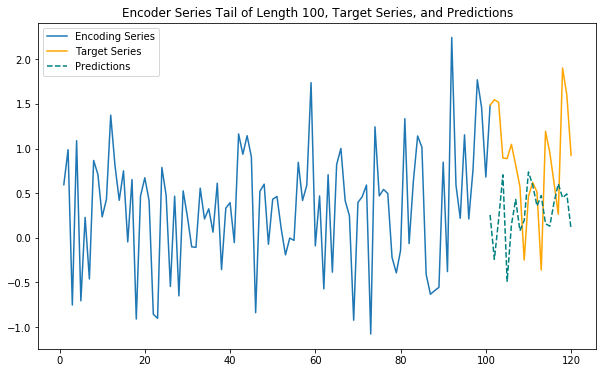

In [12]:
predict_and_plot(model, val_generator[0][0], val_generator[0][1],
                 1, pred_steps = 20)

In [44]:
# def get_corr_mae(model,
#                  input_sequnece_batch,
#                  target_sequence_batch,
#                  sample_ix,
#                  pred_steps: int,
#                  enc_tail_len=50,
#                  verbose=True):
#     input_sequence = input_sequnece_batch[sample_ix]
#     target_sequence = target_sequence_batch[sample_ix]
#     pred_series = models.predict_sequence_m2o(input_sequence,
#                                               pred_steps, model, 114)
#     input_sequence = input_sequence.reshape(-1,1)
#     pred_series = pred_series.reshape(-1,1)   
#     target_sequnece = target_sequence.reshape(pred_steps,1)
#     input_sequence_tail = np.concatenate([input_sequence[-enc_tail_len:],target_sequence[:1]])
#     x_encode = input_sequence_tail.shape[0]
    
#     r, p = pearsonr(pred_series.reshape(-1), target_sequence.reshape(-1))
#     mae = np.mean(np.abs(pred_series.reshape(-1) - target_sequence.reshape(-1)))
#     if verbose:
#         print(f"Correlation: {r}. P: {p}. MAE: {mae}")
#     return r, mae

In [14]:
def get_corr_mae(encoder_input_data, decoder_target_data, inf_target,
                 sample_ix, electrode: int,
                 pred_steps: int,
                 enc_tail_len=100, verbose=True):
    encode_series = encoder_input_data[sample_ix:sample_ix+1,:,:] 
    history_sequence_target = inf_target[sample_ix, :, :]
    pred_series = predict_sequence_m2o(encode_series,
                                       history_sequence_target,
                                       pred_steps,
                                       electrode,
                                       model)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    return r, mae

In [15]:
encoder_input_data = val_batch[0]
encoder_target_data = val_batch[1]

In [64]:
n_rows = int(encoder_input_data.shape[0]//2)
r_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(encoder_input_data, encoder_target_data,
                          inf_batch[1],
                          sample_ix=sample_ix, electrode=electrode,
                          pred_steps=20, verbose=False)
    r_array[sample_ix] = r
    sample_maes[sample_ix] = mae
z_mean = np.mean(r_array)
batch_r = np.tanh(z_mean)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Batch Mae: {batch_mae}")

Batch_r: 0.021609686888492345
Batch Mae: 0.6459718751826439


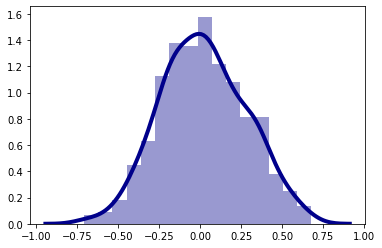

In [65]:
# Plot the distribution of r
import seaborn as sns
sns.distplot(r_array, kde=True, color = 'darkblue',
             kde_kws={'linewidth': 4})

In [66]:
k = 5
top_k_r = np.abs(r_array).argsort()[:k]
print(top_k_r)

[262 120 253 300   9]


Correlation: 0.0003314349161636365. P: 0.998893514647435. Mae: 0.5825218847876681
Correlation: 0.00043329275571606096. P: 0.9985534656591529. Mae: 0.5281221882109877
Correlation: -0.0008184188800947345. P: 0.9972677376259851. Mae: 0.5434880023862295
Correlation: -0.0009516200830506916. P: 0.9968230521365179. Mae: 0.4810543061397671
Correlation: 0.002015468732375403. P: 0.9932714900613938. Mae: 0.802284507300836


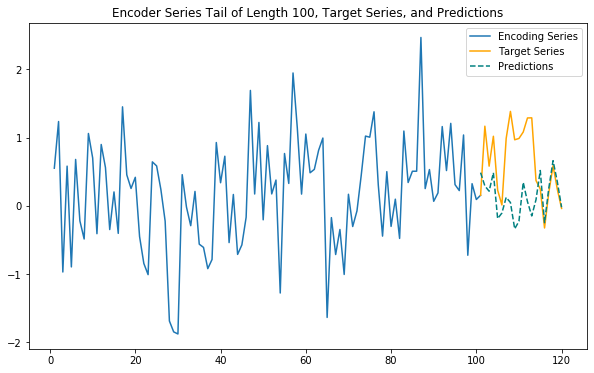

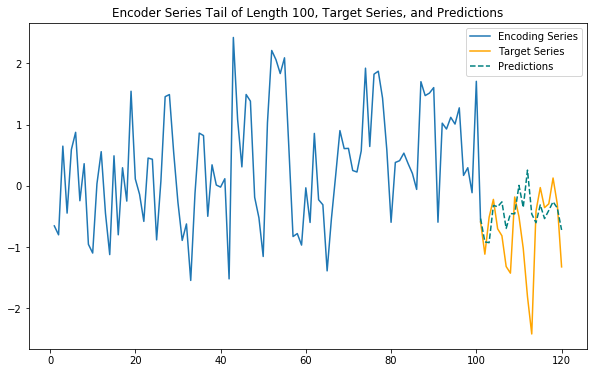

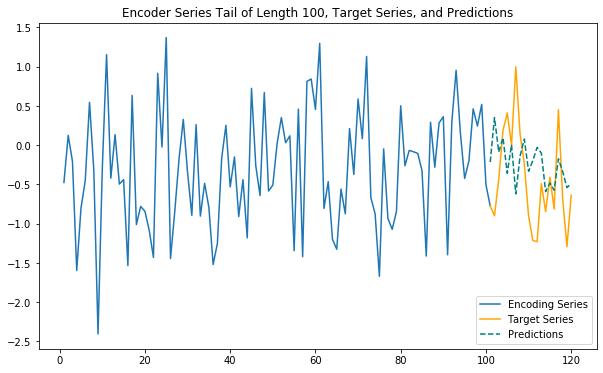

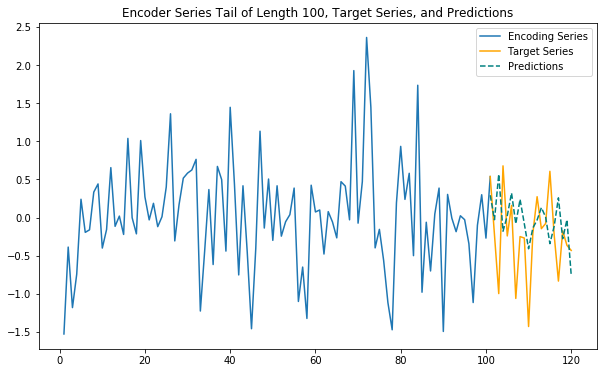

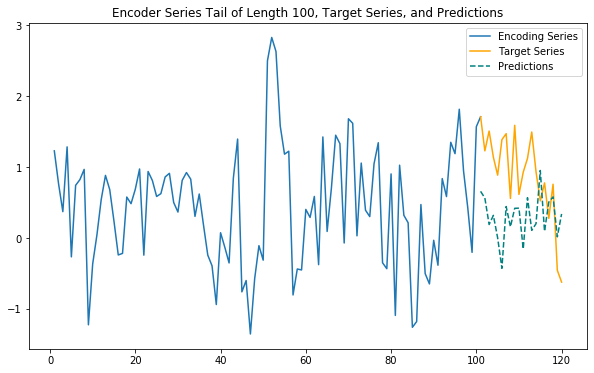

In [67]:
for i in top_k_r:
    predict_and_plot(val_batch[0], val_batch[1], inf_batch[1], sample_ix=i, electrode=electrode,
                     pred_steps=20)

In [68]:
k = 5
top_k_mae = sample_maes.argsort()[:k]
print(top_k_mae)

[110  31 118 248 495]


Correlation: 0.5639428416409606. P: 0.009601805537563077. Mae: 0.2401523272406036
Correlation: 0.6780017367827772. P: 0.0010187515607285311. Mae: 0.27022467169319536
Correlation: 0.3450276538043975. P: 0.13626338902759189. Mae: 0.31641560292716625
Correlation: 0.3630326203826668. P: 0.11566788228463984. Mae: 0.3285298122229224
Correlation: 0.3598486040087713. P: 0.11913626107837007. Mae: 0.33892620209653895


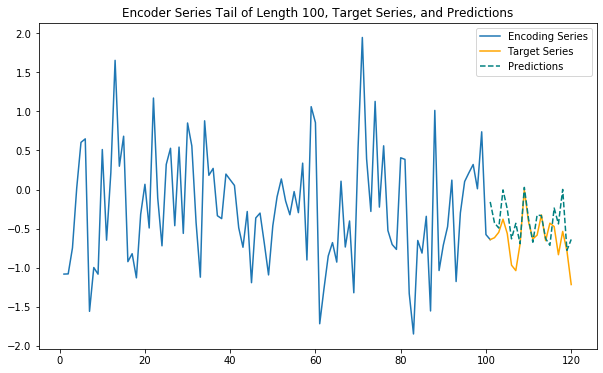

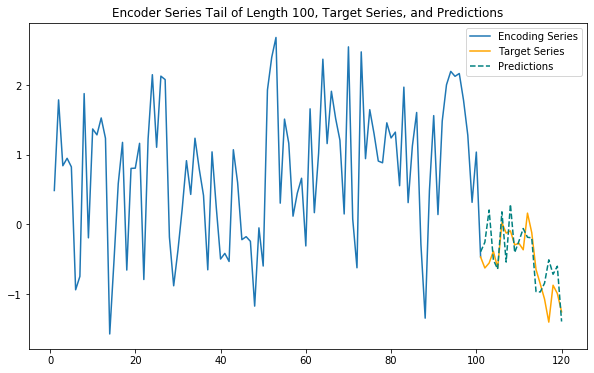

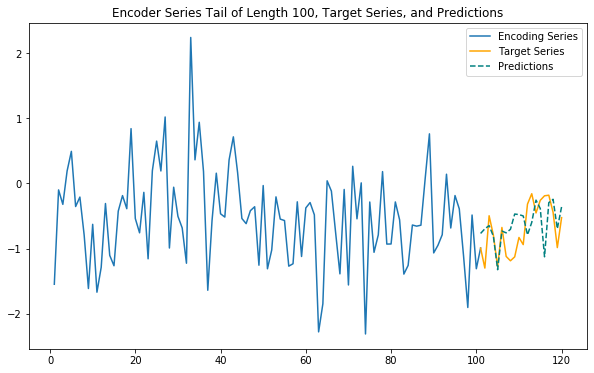

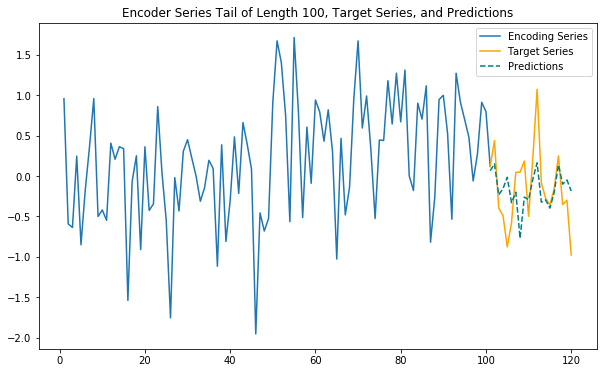

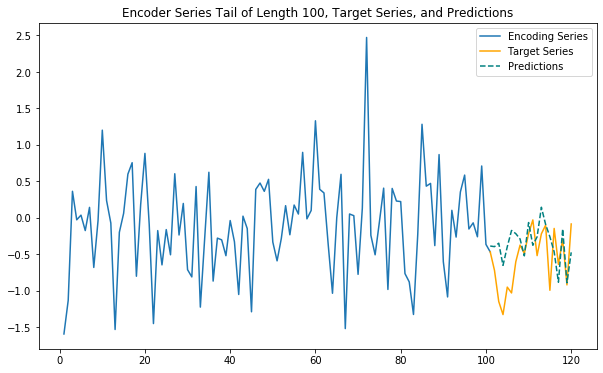

In [69]:
for i in top_k_mae:
    predict_and_plot(val_batch[0], val_batch[1], inf_batch[1], sample_ix=i, electrode=electrode,
                     pred_steps=20)

In [16]:
target_electrode=electrode
lookback=100
pred_length=20
val_paths = val_bin_norm_paths

In [17]:
def predict_sequence_m2o_window(input_sequence,
                                history_sequence_target,
                                pred_steps,
                                target_electrode,
                                electrodes,
                                model=model,
                                lookback=lookback):
    electrode_count = len(electrodes)
    pred_sequence = np.zeros((pred_steps,)) # initialize output (pred_steps time steps)  
    history_sequence = input_sequence
    history_sequence_target = np.array([history_sequence_target])

#     print(history_sequence.shape)

    for i in range(pred_steps):
        # record next time step prediction (last time step of model output) 
        history_sequence = history_sequence.reshape((1, lookback, len(electrodes)))
#         print(history_sequence.shape)
        last_step_pred = model.predict(history_sequence)
#         last_step_pred = last_step_pred.reshape(-1)
        
        pred_sequence[i] = last_step_pred[:, -1, :]
#         print(pred_sequence.shape)
        history_sequence_target[0, i, electrode] = pred_sequence[i]
#         print(history_sequence_target.shape)
#         print(history_sequence_target[:, i, electrode].shape)
#         print(history_sequence_target[:, i, :].shape)
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence[:, -(lookback-1):, :], 
                                           history_sequence_target[:, i, :].reshape(1, 1, electrode_count)], axis=1)
#     print(len(pred_sequence))
    return pred_sequence

def moving_window_pred_m2o(input_sequence,
                           lookback,
                           pred_steps,
                           electrode_count,
                           electrodes,
                           target_electrode,
                           model):
    # for each window of lookback predict steps and then
    # move window up by pred steps and repeat
    # window = input_sequence[w_start: w_end]
    final_array = np.empty(shape=(input_sequence.shape[0], 1))
    print(final_array.shape)
    w_start = 0
    w_end = w_start + lookback
    final_array[w_start : w_end] = input_sequence[w_start : w_end, target_electrode].reshape(lookback, 1)
    history_sequence_target = input_sequence
    while w_end + pred_steps < input_sequence.shape[0]:
        window_lookback = input_sequence[w_start: w_end, electrodes]
        pred_seq = predict_sequence_m2o_window(window_lookback,
                                               history_sequence_target,
                                               pred_steps,
                                               target_electrode = target_electrode,
                                               electrodes = electrodes,
                                               model=model,
                                               lookback=lookback)
#         print(pred_seq.shape)
        final_array[w_end:w_end+pred_steps] = pred_seq.reshape(pred_steps, 1)
        w_start += pred_steps
        w_end += pred_steps
    return final_array

def get_corr_mae_conv(input_seq,
                      lookback,
                      pred_length,
                      electrode_count,
                      electrodes,
                      target_electrode,
                      model,
                      enc_tail_len=100,
                      verbose=True):
    
    
    print(input_seq.shape)
    input_seq = input_seq[:,[*electrodes]].reshape(input_seq.shape[0], electrode_count)

    predicted_series = moving_window_pred_m2o(input_seq,
                                              lookback = lookback,
                                              pred_steps = pred_length,
                                              target_electrode=target_electrode,
                                              electrodes = electrodes,
                                              electrode_count=electrode_count,
                                              model=model)
    
    input_seq = input_seq[lookback:, target_electrode]
    print(input_seq.shape)
    predicted_series = predicted_series[lookback:,:]

    input_series = input_seq.reshape(-1,1)
    pred_series = predicted_series.reshape(-1,1)   
    
    x_encode = input_series.shape[0]
    print(input_series.shape)
    print(pred_series.shape)
    r, p = pearsonr(pred_series.reshape(-1), input_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - input_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    plt.plot(range(x_encode),input_series)
    plt.plot(range(x_encode),pred_series,color='orange',linestyle='--')
    plt.legend(['Input Series', 'Predictions'])
    return r, mae

In [18]:
data = np.load(val_bin_norm_paths[0])

In [19]:
target_electrode = electrode

In [20]:
target_electrode

5

In [21]:
pred_length = 20

(2000, 114)
(2000, 1)
(1900,)
(1900, 1)
(1900, 1)
Correlation: 0.16163282567054732. P: 1.3663047620547657e-12. MAE: 0.7343039586063674


(0.16163282567054732, 0.7343039586063674)

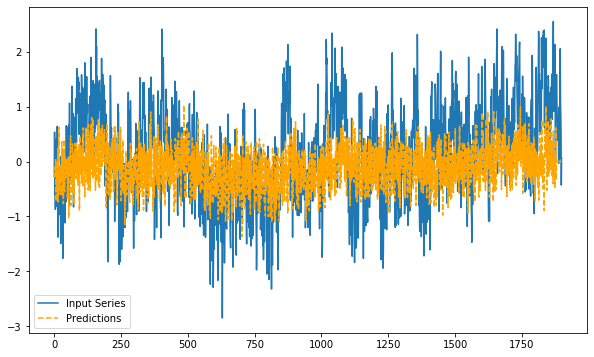

In [82]:
get_corr_mae_conv(data[:2000,:],
                  lookback,
                  pred_length, electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(1100, 114)
(1100, 1)
(1000,)
(1000, 1)
(1000, 1)
Correlation: 0.16345487499290462. P: 2.020679282351323e-07. MAE: 0.6727403068506361


(0.16345487499290462, 0.6727403068506361)

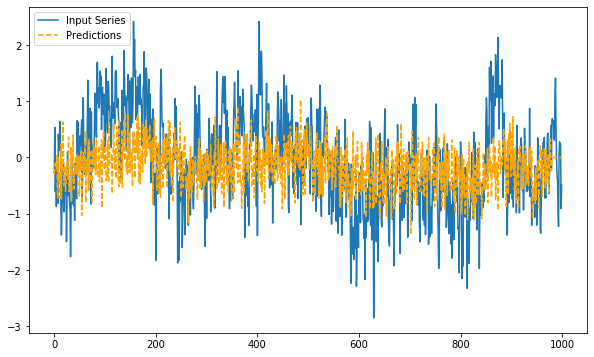

In [86]:
get_corr_mae_conv(data[:1100,:],
                  lookback,
                  pred_length, electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

In [83]:
def get_corr_mae_conv_step(input_seq,
                      lookback,
                      pred_length,
                      k,
                      electrode_count,
                      electrodes,
                      target_electrode,
                      model,
                      enc_tail_len=100,
                      verbose=True):
    
    
    print(input_seq.shape)
    input_seq = input_seq[:,[*electrodes]].reshape(input_seq.shape[0], electrode_count)

    predicted_series = moving_window_pred_m2o_step(input_seq,
                                                   lookback = lookback,
                                                   pred_steps = pred_length,
                                                   k=k,
                                                   target_electrode=target_electrode,
                                                   electrodes = electrodes,
                                                   electrode_count=electrode_count,
                                                   model=model)
    
    input_seq = input_seq[lookback + k:, target_electrode]
    print(input_seq.shape)

    input_series = input_seq.reshape(-1,1)
    predicted_series = predicted_series[lookback + k:,target_electrode]
    pred_series = predicted_series.reshape(-1,1)   
    
    x_encode = input_series.shape[0]
    print(input_series.shape)
    print(pred_series.shape)
    r, p = pearsonr(pred_series.reshape(-1), input_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - input_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    plt.plot(range(x_encode),input_series)
    plt.plot(range(x_encode),pred_series,color='orange',linestyle='--')
    plt.legend(['Input Series', 'Predictions'])
    return r, mae

def moving_window_pred_m2o_step(input_sequence,
                                lookback,
                                pred_steps,
                                k,
                                target_electrode,
                                electrodes,
                                electrode_count,
                                model):
    # for each window of lookback predict steps and then
    # move window up by pred steps and repeat
    # window = input_sequence[w_start: w_end]
    
    electrode_count = len(electrodes)
    final_array = np.empty(shape=(input_sequence.shape[0], electrode_count))
    
    w_start = 0
    w_end = w_start + lookback
    final_array[w_start : w_end + k, :] = input_sequence[w_start : w_end + k, :]
    print(final_array.shape)
    full_length = int(len(input_sequence))
    print(full_length)
    i = w_end + k
    while i < full_length:
        window_lookback = np.array([input_sequence[w_start: w_end, [*electrodes]]])
#         print(window_lookback.shape)
        pred_steps = model.predict(window_lookback)
#         print(pred_steps.reshape((20, 1)))
#         print(pred_steps.shape)
        final_array[w_end + k] = pred_steps[:,k,:].reshape((1, 1))
        w_end += 1
        w_start += 1
        i += 1
    return final_array

(1100, 114)
(1100, 114)
1100
(1000,)
(1000, 1)
(1000, 1)
Correlation: 0.23784424375421523. P: 2.507076801458165e-14. MAE: 0.6826918470623655


(0.23784424375421523, 0.6826918470623655)

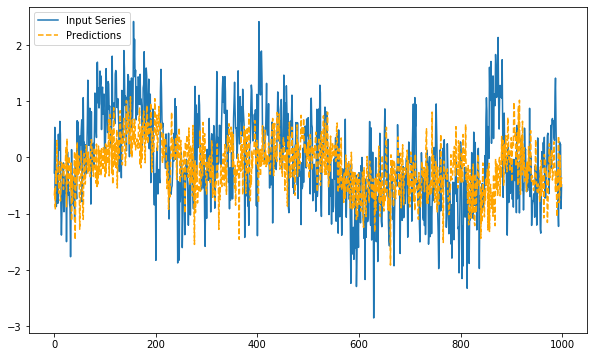

In [87]:
get_corr_mae_conv_step(data[:1100,:],
                  lookback,
                  pred_length, 0,electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(1100, 114)
(1100, 114)
1100
(995,)
(995, 1)
(995, 1)
Correlation: 0.2579099190302474. P: 1.3921215887551685e-16. MAE: 0.666001925448335


(0.2579099190302474, 0.666001925448335)

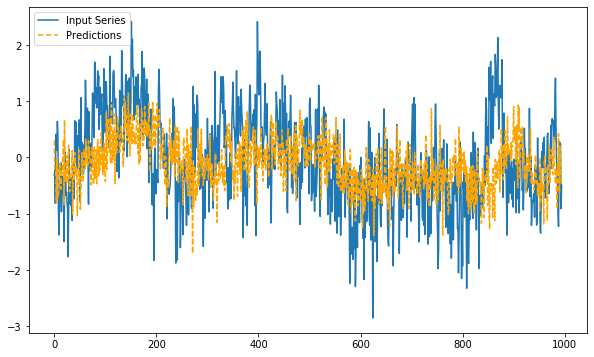

In [88]:
get_corr_mae_conv_step(data[:1100,:],
                  lookback,
                  pred_length, 5,electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

# TEST DATA

In [22]:
test_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/test_676_bin_norm_2.txt")

In [23]:
test_paths[0]

'/projects/HASSON/247/data/binned_conversations/676_bin_norm_2/bin_norm_2_NY676_618_Part5-one_conversation1/bin_norm_2_NY676_618_Part5-one_conversation1.npy'

In [24]:
for path in test_paths:
    utils.get_file_shape(path)

(163846, 114)
(102096, 114)
(73475, 114)
(33158, 114)
(17795, 114)
(64950, 114)
(92170, 114)
(83951, 114)
(42936, 114)
(21311, 114)


In [25]:
target_electrode = electrode

In [26]:
test_data = np.load(test_paths[0])

(1100, 114)
(1100, 1)
(1000,)
(1000, 1)
(1000, 1)
Correlation: 0.010463776710654054. P: 0.7410306044443681. MAE: 0.7714169138260517


(0.010463776710654054, 0.7714169138260517)

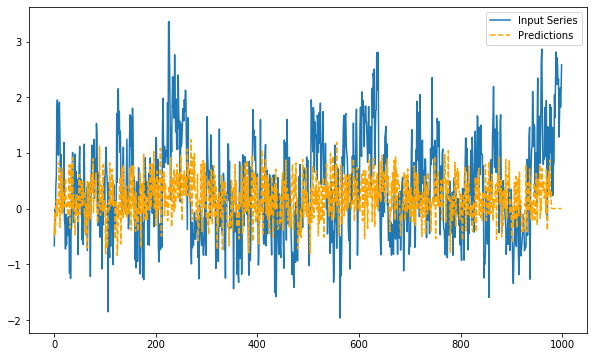

In [27]:
get_corr_mae_conv(test_data[:1100,:],
                  lookback,
                  pred_length, electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(1100, 114)
(1100, 1)
(1000,)
(1000, 1)
(1000, 1)
Correlation: 0.06682506500864469. P: 0.034608196422203724. MAE: 0.7925339191850841


(0.06682506500864469, 0.7925339191850841)

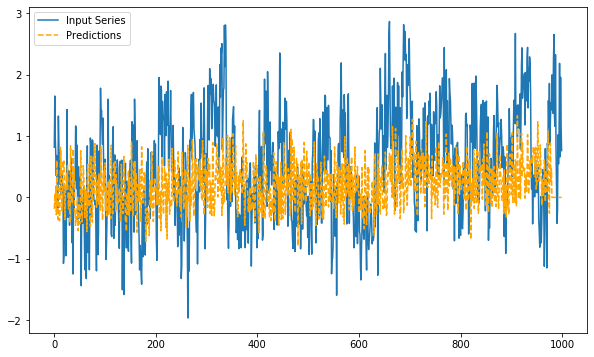

In [94]:
get_corr_mae_conv(test_data[300:1400,:],
                  lookback,
                  pred_length, electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(350, 114)
(350, 1)
(250,)
(250, 1)
(250, 1)
Correlation: 0.1030927654901885. P: 0.10390572693637501. MAE: 0.6579239250620539


(0.1030927654901885, 0.6579239250620539)

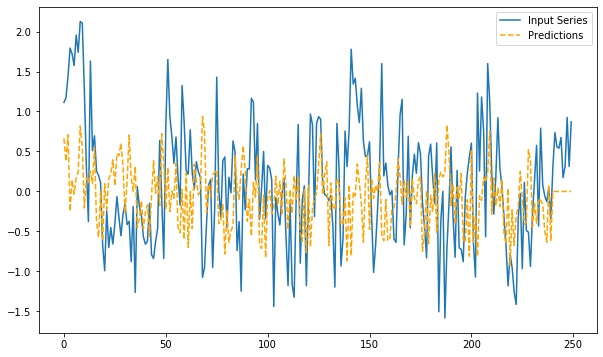

In [95]:
get_corr_mae_conv(test_data[250:600,:],
                  lookback,
                  pred_length, electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(2100, 114)
(2100, 1)
(2000,)
(2000, 1)
(2000, 1)
Correlation: 0.06709453757443334. P: 0.0026815383657031624. MAE: 0.7682878377791033


(0.06709453757443334, 0.7682878377791033)

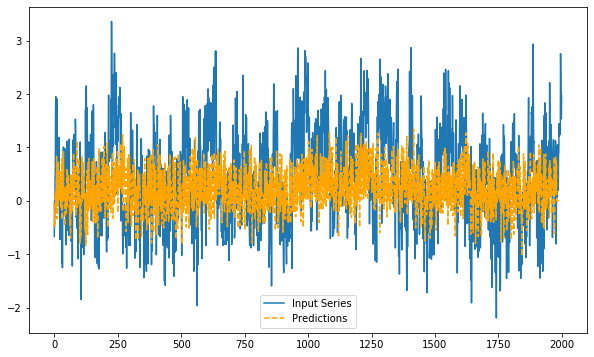

In [109]:
get_corr_mae_conv(test_data[:2100,:],
                  lookback,
                  pred_length, electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(300, 114)
(300, 114)
300
(200,)
(200, 1)
(200, 1)
Correlation: 0.38256414401634964. P: 2.2642825273970875e-08. MAE: 0.7145115948572712


(0.38256414401634964, 0.7145115948572712)

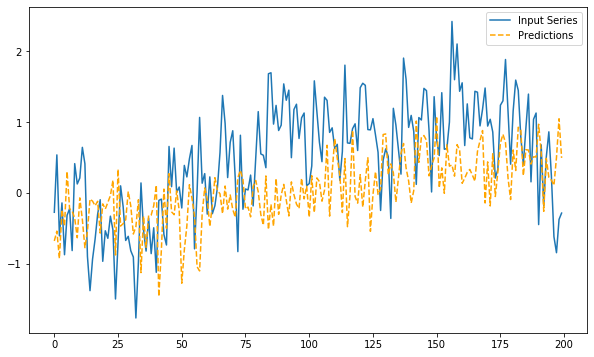

In [97]:
get_corr_mae_conv_step(data[:300,:],
                  lookback,
                  pred_length, 0,electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(1100, 114)
(1100, 114)
1100
(1000,)
(1000, 1)
(1000, 1)
Correlation: 0.23784424375421523. P: 2.507076801458165e-14. MAE: 0.6826918470623655


(0.23784424375421523, 0.6826918470623655)

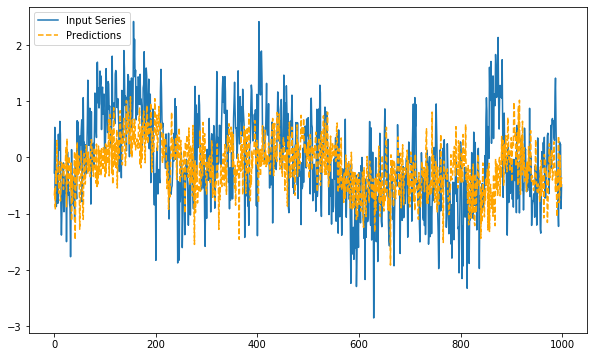

In [98]:
get_corr_mae_conv_step(data[:1100,:],
                  lookback,
                  pred_length, 0,electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(1100, 114)
(1100, 114)
1100
(995,)
(995, 1)
(995, 1)
Correlation: 0.2579099190302474. P: 1.3921215887551685e-16. MAE: 0.666001925448335


(0.2579099190302474, 0.666001925448335)

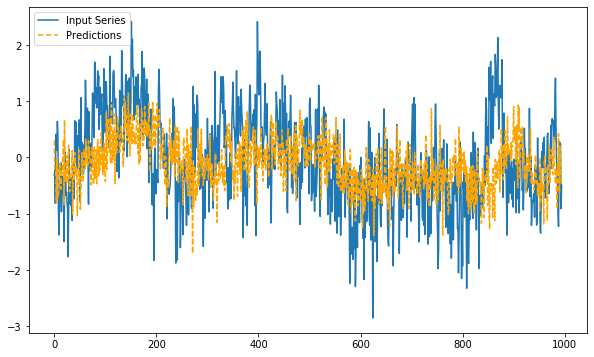

In [99]:
get_corr_mae_conv_step(data[:1100,:],
                  lookback,
                  pred_length, 5,electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

(1100, 114)
(1100, 114)
1100
(990,)
(990, 1)
(990, 1)
Correlation: 0.26999201172968207. P: 5.360671518775455e-18. MAE: 0.6657918525159908


(0.26999201172968207, 0.6657918525159908)

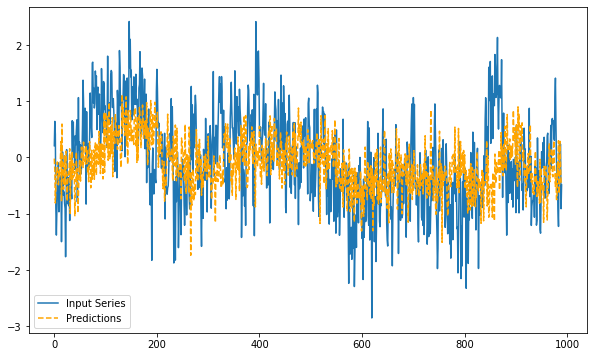

In [100]:
get_corr_mae_conv_step(data[:1100,:],
                  lookback,
                  pred_length, 10,electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)

In [101]:
# Test_gene
test_generator = generators.FGenerator(file_paths=test_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=2048,
                                        sample_period=1,
                                        electrodes=electrodes,
                                        electrode_output_ix=target_electrode,
                                        shuffle=False)

In [102]:
len(test_generator)

2

In [103]:
test_batch = test_generator[0]

In [104]:
encoder_input_data = test_batch[0]
encoder_target_data = test_batch[1]

In [107]:
n_rows = int(encoder_input_data.shape[0]//2)
r_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(encoder_input_data, encoder_target_data,
                      inf_batch[1],
                      sample_ix=sample_ix, electrode=electrode,
                      pred_steps=20, verbose=False)
    r_array[sample_ix] = r
    sample_maes[sample_ix] = mae
z_mean = np.mean(r_array)
batch_r = np.tanh(z_mean)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Batch Mae: {batch_mae}")

Batch_r: 0.018690397525242663
Batch Mae: 0.7568328494296273
